In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -qq /content/drive/MyDrive/Dataset-No-Augmentation.zip -d dataset

Imports

In [3]:
import tensorflow as tf
from tensorflow import keras
import pathlib
import numpy as np
import os
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

Load the data

In [4]:
data_dir = pathlib.Path('dataset')
audio_count = len(list(data_dir.glob('*/*.wav')))
print(audio_count)

3682


In [30]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.wav'), shuffle=False)
list_ds = list_ds.shuffle(audio_count, reshuffle_each_iteration=False, seed=42)

Visualize the data

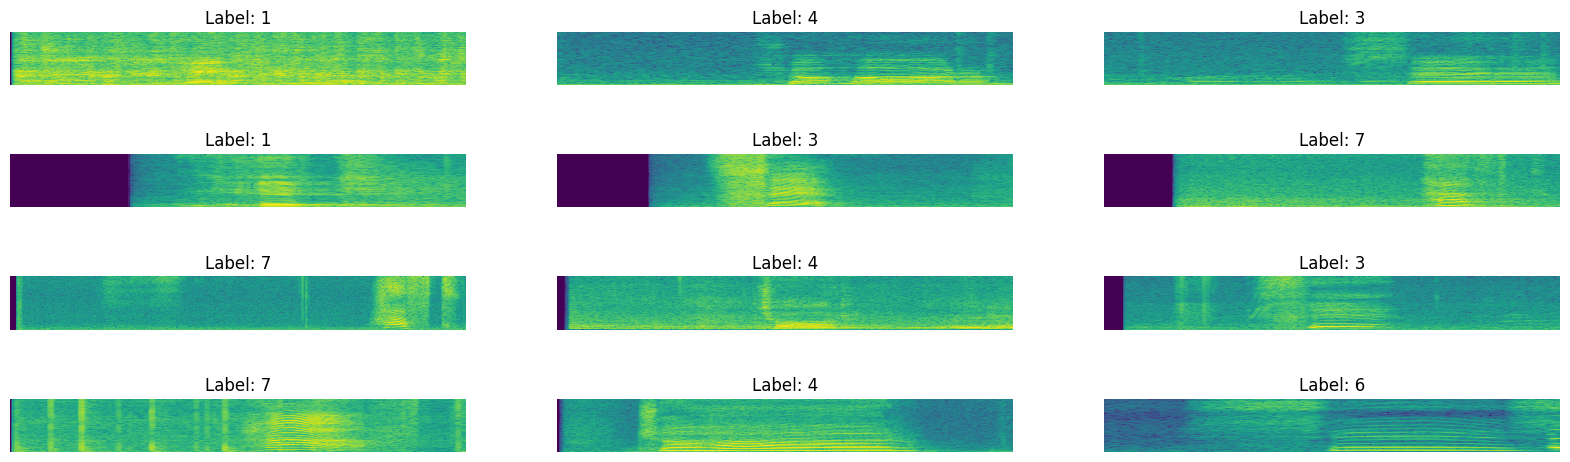

In [40]:
num_samples = 12

def process_path(file_path):
    label = get_label(file_path)

    audio = tf.io.read_file(file_path)
    wav, sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)

    spectrum = tf.abs(tf.signal.stft(wav, frame_length=511, frame_step=64))
    log_spec = np.log(spectrum.numpy().T + np.finfo(np.float32).eps)

    return log_spec, label

fig = plt.figure(figsize=(20, 15))

for i, file_path in enumerate(list_ds.take(num_samples)):
    if i >= num_samples: break

    log_spec, label = process_path(file_path)

    ax = plt.subplot(10, 3, i + 1)
    ax.pcolormesh(log_spec)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

fig.subplots_adjust(hspace=1.3)
plt.show()


In [31]:
val_size = int(audio_count * 0.1)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

Create Dataset objects

In [6]:
frame_length = 256
frame_step = 160
fft_length = 384

In [7]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  label = int(parts[-2])
  return label

In [8]:
def decode_audio(audio):
  audio, _ = tf.audio.decode_wav(audio, desired_channels=-1)
  audio = tf.reduce_mean(audio, axis=1)
  audio = tf.cast(audio, tf.float32)
  spectrogram = tf.signal.stft(
      audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
  )
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.math.pow(spectrogram, 0.5)
  means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
  stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
  spectrogram = (spectrogram - means) / (stddevs + 1e-10)
  shape = tf.shape(spectrogram)
  height, width = shape[0], shape[1]
  pad_height = 1631 - height
  pad_width = 193 - width
  padded_spectrogram = tf.pad(
        spectrogram,
        paddings=[[0, pad_height], [0, pad_width]],
        mode='CONSTANT',
        constant_values=0
    )
  return padded_spectrogram

In [9]:
def process_path(file_path):
  label = get_label(file_path)
  audio = tf.io.read_file(file_path)
  spectrogram = decode_audio(audio)
  return spectrogram, label

In [32]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [33]:
for audio, label in train_ds.take(1):
  print("Audio shape: ", audio.numpy().shape)
  print("Label: ", label)

Audio shape:  (1631, 193)
Label:  tf.Tensor(4, shape=(), dtype=int32)


In [13]:
batch_size = 32
train_ds = (
    train_ds.batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

val_ds = (
    val_ds.batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Model

In [15]:
def residual_block(x, filters, kernel_size=3, stride=1, dropout_rate=0.3):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)

    if shortcut.shape[-1] != x.shape[-1] or stride != 1:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    return x

def build_resnet(input_shape, num_classes, dropout_rate=0.3):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    x = residual_block(x, 64, dropout_rate=dropout_rate)
    x = residual_block(x, 128, stride=2, dropout_rate=dropout_rate)
    x = residual_block(x, 256, stride=2, dropout_rate=dropout_rate)
    x = residual_block(x, 512, stride=2, dropout_rate=dropout_rate)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

input_shape = (1631, 193, 1)
num_classes = 10
dropout_rate = 0.3

model = build_resnet(input_shape, num_classes, dropout_rate)

model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 1631, 193, 1)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 816, 97, 64)    │          3,200 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 816, 97, 64)    │            256 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_9 (ReLU)            │ (None, 816, 97, 64)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 408, 49, 64)    │              0 │ re_lu_9[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 408, 49, 64)    │         36,928 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 408, 49, 64)    │            256 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_10 (ReLU)           │ (None, 408, 49, 64)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 408, 49, 64)    │              0 │ re_lu_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 408, 49, 64)    │         36,928 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 408, 49, 64)    │            256 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 408, 49, 64)    │              0 │ batch_normalization_1… │
│                           │                        │                │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_11 (ReLU)           │ (None, 408, 49, 64)    │              0 │ add_4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 408, 49, 64)    │              0 │ re_lu_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 204, 25, 128)   │         73,856 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 204, 25, 128)   │            512 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 4,913,290 (18.74 MB)

 Trainable params: 4,907,530 (18.72 MB)

 Non-trainable params: 5,760 (22.50 KB)

In [16]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=3, min_lr=0.000001)

In [17]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/best_model.weights.h5', save_best_only=True, monitor='val_accuracy', mode='max', save_weights_only=True, verbose=1)

Training

In [18]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[reduce_lr, checkpoint_callback]
)

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.1489 - loss: 2.2730
Epoch 1: val_accuracy improved from -inf to 0.11413, saving model to /content/drive/MyDrive/best_model.weights.h5
104/104 ━━━━━━━━━━━━━━━━━━━━ 117s 730ms/step - accuracy: 0.1493 - loss: 2.2718 - val_accuracy: 0.1141 - val_loss: 4.2862 - learning_rate: 0.0010
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.3564 - loss: 1.8046
Epoch 2: val_accuracy improved from 0.11413 to 0.29891, saving model to /content/drive/MyDrive/best_model.weights.h5
104/104 ━━━━━━━━━━━━━━━━━━━━ 73s 371ms/step - accuracy: 0.3567 - loss: 1.8038 - val_accuracy: 0.2989 - val_loss: 2.5721 - learning_rate: 0.0010
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.5056 - loss: 1.3952
Epoch 3: val_accuracy did not improve from 0.29891
104/104 ━━━━━━━━━━━━━━━━━━━━ 39s 352ms/step - accuracy: 0.5059 - loss: 1.3946 - val_accuracy: 0.1440 - val_loss: 6.9385 - learning_rate: 0.0010
Epoch 4/20
104/104 ━━

In [22]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[reduce_lr, checkpoint_callback]
)

Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9827 - loss: 0.0588
Epoch 1: val_accuracy improved from 0.88043 to 0.89130, saving model to /content/drive/MyDrive/best_model.weights.h5
104/104 ━━━━━━━━━━━━━━━━━━━━ 70s 490ms/step - accuracy: 0.9827 - loss: 0.0587 - val_accuracy: 0.8913 - val_loss: 0.4320 - learning_rate: 1.0000e-04
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.9919 - loss: 0.0380
Epoch 2: val_accuracy did not improve from 0.89130
104/104 ━━━━━━━━━━━━━━━━━━━━ 37s 353ms/step - accuracy: 0.9919 - loss: 0.0380 - val_accuracy: 0.8913 - val_loss: 0.4065 - learning_rate: 1.0000e-04
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9947 - loss: 0.0311
Epoch 3: val_accuracy improved from 0.89130 to 0.89402, saving model to /content/drive/MyDrive/best_model.weights.h5
104/104 ━━━━━━━━━━━━━━━━━━━━ 42s 362ms/step - accuracy: 0.9947 - loss: 0.0311 - val_accuracy: 0.8940 - val_loss: 0.3841 - learning_rate: 1.0000e-04
Epoch 4

In [23]:
model.load_weights('/content/drive/MyDrive/best_model.weights.h5')

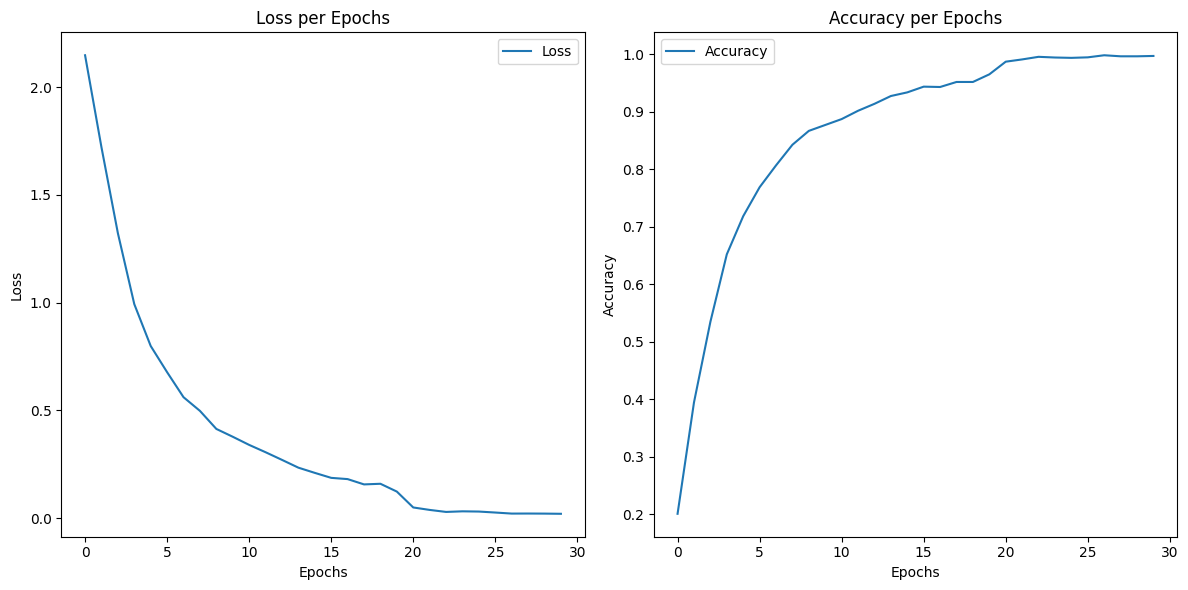

In [24]:
loss_history = history.history['loss'] + history1.history['loss']
accuracy_history = history.history['accuracy'] + history1.history['accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss')
plt.title('Loss per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Accuracy')
plt.title('Accuracy per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Prediction

In [25]:
predictions = []
targets = []
for batch in val_ds:
    X, y = batch
    pred = model.predict(X, verbose=0)
    predictions.extend(tf.argmax(pred, axis=1))
    for label in y:
        targets.append(label)

Analysis

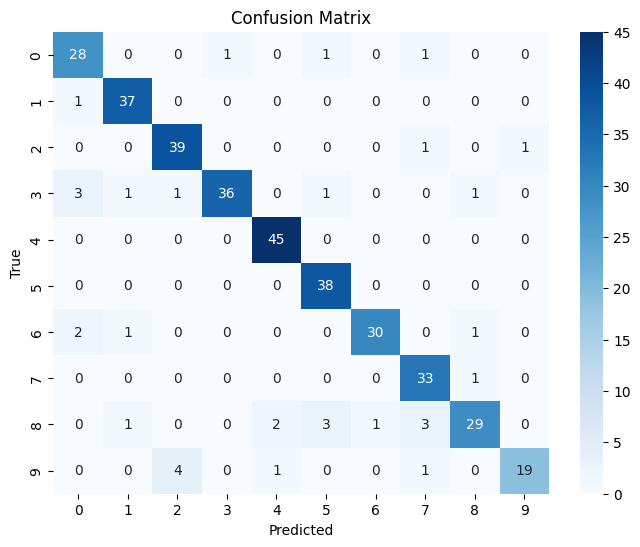

In [27]:
cm = confusion_matrix(targets, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[0]), yticklabels=np.arange(cm.shape[0]))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
print("Classification Report:\n")
print(classification_report(targets, predictions))

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        31
           1       0.93      0.97      0.95        38
           2       0.89      0.95      0.92        41
           3       0.97      0.84      0.90        43
           4       0.94      1.00      0.97        45
           5       0.88      1.00      0.94        38
           6       0.97      0.88      0.92        34
           7       0.85      0.97      0.90        34
           8       0.91      0.74      0.82        39
           9       0.95      0.76      0.84        25

    accuracy                           0.91       368
   macro avg       0.91      0.90      0.90       368
weighted avg       0.91      0.91      0.91       368

